In [140]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Tenemos un pequeño dataset de imágenes basado en [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).

- cada imagen es de **32x32x3**.
- las imágenes se **linearizan** para la red que ensamblamos con Keras, compuesta por capas tradicionales (**Dense**).
- en ejemplos más sofisticados usaríamos **capas convolucionales** que explotan las correlaciones 2D propias de las imágenes.

In [217]:
def show_image_mosaic(imgs, labels, figsize=(12, 12), idxs=None):

    plt.figure(figsize=figsize)
    for labi,lab in [i for i in enumerate(np.unique(labels))]:
        k = imgs[labels == lab]
        _idxs = idxs[:10] if idxs is not None else np.random.permutation(len(k))[:10]
        for i, idx in enumerate(_idxs):
            if i == 0:
                plt.subplot(10, 11, labi*11+1)
                plt.title("LABEL %d" % lab)
                plt.plot(0, 0)
                plt.axis("off")

            img = k[idx]
            plt.subplot(10, 11, labi*11+i+2)
            plt.imshow(img, cmap=plt.cm.Greys_r)
            plt.axis("off")

In [218]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

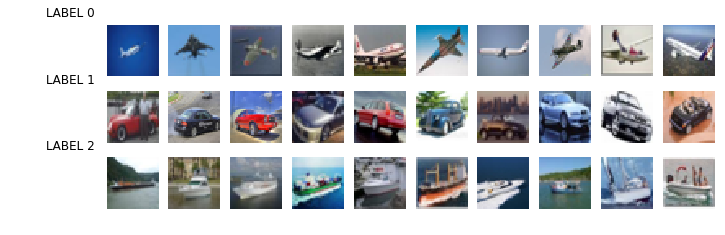

In [219]:
show_image_mosaic(x_cifar, y_cifar)

In [220]:
from sklearn.model_selection import train_test_split

In [221]:
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print "\ndistribution of train classes"
print pd.Series(y_train).value_counts()
print "\ndistribution of test classes"
print pd.Series(y_test).value_counts()

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    781
1    755
0    717
dtype: int64

distribution of test classes
0    288
2    244
1    219
dtype: int64


construimos el modelo con Keras

In [222]:
num_classes = len(np.unique(y_cifar))


In [223]:
def get_model(num_classes, img_size=32, compile=True):
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Flatten(name="flatten")(inputs)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu, name="dense_1")(layers)
    layers = tf.keras.layers.Dropout(0.2, name="dropout")(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [224]:
num_classes = len(np.unique(y_cifar))
model = get_model(num_classes)

using 3 classes


observa los pesos inicializados y sus tamaños

In [225]:
weights = model.get_weights()
for i in weights:
    print i.shape

(3072, 16)
(16,)
(16, 3)
(3,)


In [226]:
weights[2]

array([[ 0.4978878 , -0.08005565,  0.42109847],
       [ 0.2974133 , -0.03092802,  0.16753232],
       [ 0.42609674,  0.49431103, -0.28950796],
       [ 0.25697434, -0.30249286, -0.4189386 ],
       [-0.48568138,  0.21872902,  0.2380994 ],
       [ 0.372477  , -0.29730704, -0.15394142],
       [-0.1398386 , -0.25754094, -0.16870934],
       [-0.48531255, -0.30670196,  0.15619642],
       [ 0.02925485,  0.3191377 ,  0.17079633],
       [-0.3158316 ,  0.3756246 , -0.51305866],
       [-0.10377917,  0.15639955,  0.05432713],
       [-0.09478754,  0.06750643, -0.03165323],
       [-0.40204942, -0.2591732 ,  0.08793592],
       [ 0.16728342, -0.21761769, -0.3149957 ],
       [ 0.13076735, -0.47401887, -0.06539735],
       [ 0.28630006,  0.4269325 ,  0.24136662]], dtype=float32)

In [227]:
num_classes = len(np.unique(y_cifar))

model = get_model(num_classes)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(time()))
model.reset_states()
model.fit(x_train, y_train, epochs=5, callbacks=[tensorboard],steps_per_epoch=10)
model.evaluate(x_test, y_test)

using 3 classes
Epoch 1/5
10/10 [==============================] - 2s 199ms/step - loss: 1.1436 - acc: 0.3649
Epoch 2/5
10/10 [==============================] - 1s 92ms/step - loss: 1.0797 - acc: 0.4051
Epoch 3/5
10/10 [==============================] - 1s 68ms/step - loss: 1.0669 - acc: 0.4248
Epoch 4/5
10/10 [==============================] - 1s 68ms/step - loss: 1.0571 - acc: 0.4427
Epoch 5/5
751/751 [==============================] - 0s 374us/step


[1.0491327799747534, 0.4260985353259685]

## preprocesado de imágenes

realizamos ahora una transformación sencilla sobre las imágenes usando las herramientas de TF

In [228]:
timgs = tf.placeholder(dtype=tf.float32, shape=(None, 32,32,3))
cimgs = tf.image.adjust_contrast(timgs, 10.)

with tf.Session() as sess:
    cx_train = sess.run(cimgs, feed_dict={timgs: x_train})
    cx_test  = sess.run(cimgs, feed_dict={timgs: x_test})

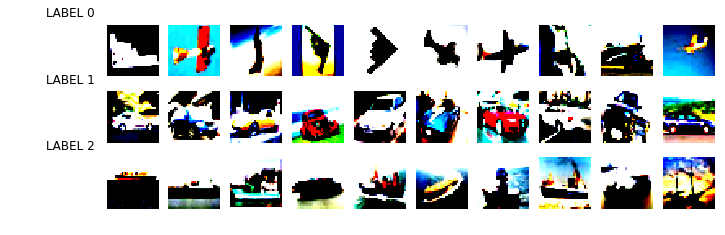

In [229]:
show_image_mosaic(cx_train, y_train)

fíjate cómo mejora la predicción

In [230]:
model = get_model(num_classes)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(time()))
model.fit(cx_train, y_train, epochs=5, callbacks=[tensorboard], steps_per_epoch=10)
model.evaluate(cx_test, y_test)

using 3 classes
Epoch 1/5
10/10 [==============================] - 1s 101ms/step - loss: 1.7208 - acc: 0.4457
Epoch 2/5
10/10 [==============================] - 1s 71ms/step - loss: 1.0256 - acc: 0.5464
Epoch 3/5
10/10 [==============================] - 1s 69ms/step - loss: 0.9118 - acc: 0.6049
Epoch 4/5
10/10 [==============================] - 1s 70ms/step - loss: 0.8355 - acc: 0.6323
Epoch 5/5
751/751 [==============================] - 0s 424us/step


[0.9239158898631679, 0.601864181131561]

## Input pipelines

pero hemos hecho toda la **transformación en memoria**, y nos gustaría implementarla como un input pipeline. Previendo esto, la transformación ya la habíamos hecho en tensorflow, por tanto podemos **integrar** el grafo computacional de la misma el grafo del modelo.

In [231]:
def get_dataset(imgs, labels, repeat, batch_size, shuffle=True):
    d1 = tf.data.Dataset.from_tensor_slices((tf.constant(imgs, dtype=tf.float32), 
                                             tf.constant(labels.reshape(-1,1), dtype=tf.float32)))

    resize    = lambda x,y: (tf.image.resize_images(x,(30,30)), y)
    transform = lambda x,y: ({"input_1": tf.image.adjust_contrast(x, 10.)},{"output_1": y})
    if shuffle:
        d1 = d1.shuffle(buffer_size=200)
    d1 = d1.map(resize)
    d1 = d1.map(transform)
    
    d1 = d1.repeat(repeat)
    d1 = d1.batch(batch_size)    
    return d1

observa que hay cierta superposición entre las nociones de batch_size, steps, epochs, repeats en keras y en el dataset API.

en realidad, keras considera cada batch que le venga de un dataset como un step. p.ej: con

- **2200 elementos** en total
- **dataset repeat=2**
- **dataset batch_size=10**

el dataset suministra un total de 2200/10*2 = 440 batches 

si en keras `fit` usamos 5 epochs de 100 `steps_per_epoch` cada uno, nos quedaremos sin datos durante el quinto epoch. A no ser qué:

- el **dataset repeat** sea -1, o lo aumentemos suficientemente
- reduzcamos el batch_size para que produzcan más batches más pequeños
- reduzcamos el número de `steps_per_epoch



In [232]:
batch_size = 20

model = get_model(num_classes, img_size=30)
train_dataset = get_dataset(x_train, y_train, repeat=-1, batch_size=100)
model.fit(train_dataset, epochs=5, steps_per_epoch=100)


using 3 classes
Epoch 1/5
100/100 [==============================] - 3s 26ms/step - loss: 0.9661 - acc: 0.5747
Epoch 2/5
100/100 [==============================] - 2s 21ms/step - loss: 0.6881 - acc: 0.6767
Epoch 3/5
100/100 [==============================] - 2s 23ms/step - loss: 0.5763 - acc: 0.7371
Epoch 4/5
100/100 [==============================] - 2s 23ms/step - loss: 0.5183 - acc: 0.7634
Epoch 5/5
100/100 [==============================] - 2s 24ms/step - loss: 0.4641 - acc: 0.7915


y de forma análoga para la evaluación

In [233]:
eval_dataset = get_dataset(x_test, y_test, repeat=1, batch_size=5)
model.evaluate(eval_dataset, steps=100)

100/100 [==============================] - 1s 5ms/step


[1.0223284889757633, 0.6340000133216381]

otra alternativa sería usar [`tf.keras.estimator.model_to_estimator`](https://www.tensorflow.org/api_docs/python/tf/keras/estimator/model_to_estimator), que convierte un modelo Keras para ser usado como cualquier otro estimador TF.

## Imágenes desde ficheros

ref https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

### descargamos imágenes de dos queries en google

In [ ]:
!pip install google_images_download

In [124]:
downloads = "/tmp/downloads"
traintest_imgs = "/tmp/imgs"

train_pct = .7

In [125]:
!rm -rf $downloads
!mkdir $downloads

In [186]:
cfg="""
{
    "Records": [
        {
            "keywords": "car",
            "format": "jpg",
            "limit": 50,
            "type": "photo",
            "size": "medium",
            "output_directory": "%s"
        },
        {
            "keywords": "truck",
            "format": "jpg",
            "limit": 50,
            "type": "photo",
            "size": "medium", 
            "output_directory": "%s"
        }
    ]
}
"""%(downloads, downloads)

In [187]:
with open(downloads+"/cfg.txt", "w") as f:
    f.write(cfg)

In [188]:
!googleimagesdownload --config_file $downloads/cfg.txt


Item no.: 1 --> Item name = car
Evaluating...
Starting Download...
Completed Image ====> 1. senna.jpg
Completed Image ====> 2. 7800.jpg
Completed Image ====> 3. 7817.jpg
Completed Image ====> 4. cr-inline-top-picks-toyota-yaris-02-17.jpg
Completed Image ====> 5. mclaren-senna-car-price-new-2018-890981.jpg
Completed Image ====> 6. pexels-photo-170811.jpeg
Completed Image ====> 7. 650.jpg
Completed Image ====> 8. 10-30000-car-giveaway.jpg
Completed Image ====> 9. 592f4169b74af41b008b5977-750-563.jpg
Completed Image ====> 10. bmw-2-series.jpg
Completed Image ====> 11. open-uri20150422-20810-1fndzcd_41017374.jpeg
Completed Image ====> 12. quattroporte_front.jpg
Completed Image ====> 13. gallardo-0638.jpg
Completed Image ====> 14. 5b64d89fe799d.jpg
Completed Image ====> 15. pexels-photo-210019.jpeg
Completed Image ====> 16. 2015-tesla-model-s-90d-black-profile-in-front-of-modern-house.jpg
Completed Image ====> 17. nissanqashqai-b0501a8342a63440547916ba367e5a52.jpg
Completed Image ====> 18.

### revisamos las imágenes y eliminamos las defectuosas

In [189]:
from skimage import io
files = !find $downloads -type f
for fname in files:
    if fname!=downloads+"/cfg.txt":
        print ".",
        try:
            io.imread(fname)
        except:
            print "\nremoving",fname,"as cannot be read\n"
            !rm '$fname'

. 
removing /tmp/downloads/truck/10. 2017-trucks-masthead-01v2.jpg as cannot be read

. . . . . 
removing /tmp/downloads/truck/24. 2018-trucks-mh-lg-18pgcn00083.jpg as cannot be read

. . . . . . . . . 
removing /tmp/downloads/truck/25. 2018-silverado-masthead-01-v2.jpg as cannot be read

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
removing /tmp/downloads/truck/38. 2018-canyon-mov-slt-quicksilver-18pgcn00110.jpg as cannot be read

. . . . . . . . . 
removing /tmp/downloads/car/34. alto800_091916050053.jpg as cannot be read

. . . . . . . . . . . . 
removing /tmp/downloads/car/1. senna.jpg as cannot be read

. . . . . . . . . . . . . . . . . . . . . . 
removing /tmp/downloads/car/19. lam1_trans_nvbqzqnjv4bqnadysv0br-4fdn_-_p756cvfcy8zlgpv4ehrkjqy7tg.jpg as cannot be read

. . 
removing /tmp/downloads/car/24. 2018_honda_cr-v_4dr-suv_touring_fq_oem_16_717.jpg as cannot be read

. . . . . . . . 
removing /tmp/downloads/car/47. volvo-xc90_trans_nvbqzqnjv4bqpvlberwd9egfpztclim

### organizamos las imágenes en train y en test

In [190]:
classdirs = !find $downloads -type d
classdirs = [i.split("/")[-1] for i in classdirs if i!=downloads]
print classdirs

['truck', 'car']


In [191]:
!rm -rf $traintest_imgs

In [192]:
for classdir in classdirs:
    print classdir
    print "    splitting files ... ",
    files = !find $downloads/$classdir -type f
    files = np.r_[files]
    n_train = int(len(files)*train_pct)
    files = np.random.permutation(files)
    files_train = files[:n_train]
    files_test  = files[n_train:]
    !mkdir -p $traintest_imgs/train/$classdir
    !mkdir -p $traintest_imgs/test/$classdir
    print "copying files"
    for f in files_train:
        !cp '$f' $traintest_imgs/train/$classdir
    for f in files_test:
        !cp '$f' $traintest_imgs/test/$classdir

truck
    splitting files ...  copying files
car
    splitting files ...  copying files


### sanity check 1

In [193]:
for classdir in classdirs:
    print classdir
    files = !find  $traintest_imgs/train/$classdir -type f
    print "      ",len(files), "train images"
    files = !find  $traintest_imgs/test/$classdir -type f
    print "      ",len(files), "test images"

truck
       32 train images
       14 test images
car
       31 train images
       14 test images


### sanity check 2

see [ImageGenerator](https://keras.io/preprocessing/image/)

In [194]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [341]:
datagen = ImageDataGenerator(rescale=1./255, fill_mode='nearest')
batch_size = 10
img_size = 32
train_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/train",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

test_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/test",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

Found 62 images belonging to 2 classes.


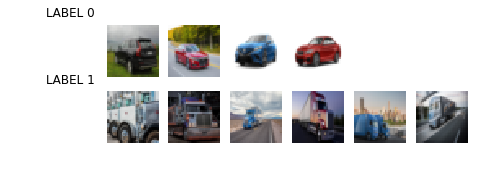

In [342]:
for imgs,labels in train_generator_fn():
    if np.random.random()>.5:
        break
        
show_image_mosaic(imgs, labels)

### train keras!!!

In [343]:
num_classes = len(classdirs)
model = get_model(num_classes, img_size=img_size)

model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=5,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)


using 2 classes
Found 62 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 24s 239ms/step - loss: 0.5187 - acc: 0.7720 - val_loss: 0.6333 - val_acc: 0.6016
Epoch 2/5
100/100 [==============================] - 25s 251ms/step - loss: 0.3052 - acc: 0.8681 - val_loss: 0.8511 - val_acc: 0.6765
Epoch 3/5
100/100 [==============================] - 25s 250ms/step - loss: 0.1883 - acc: 0.9321 - val_loss: 0.9489 - val_acc: 0.7166
Epoch 4/5
100/100 [==============================] - 26s 255ms/step - loss: 0.1290 - acc: 0.9600 - val_loss: 1.0020 - val_acc: 0.7139
Epoch 5/5
100/100 [==============================] - 25s 255ms/step - loss: 0.0907 - acc: 0.9670 - val_loss: 1.1473 - val_acc: 0.7166


### predictions

In [345]:
def show_preds(x, preds):
    for i  in np.random.permutation(range(len(preds)))[:4]:
        plt.figure(figsize=(5,2.5))
        plt.subplot(122)
        plt.imshow(x[i])
        plt.axis("off")
        plt.subplot(121)
        plt.bar(np.arange(2), preds[i], color="blue", alpha=.5, label="prediction")
        plt.bar(np.arange(2), np.eye(2,2)[int(y[i])], color="red", alpha=.5, label="label")
        plt.xticks(range(2), range(2), rotation="vertical");
        plt.xlim(-.5,1.5);
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, +1.35),ncol=5)


Found 28 images belonging to 2 classes.


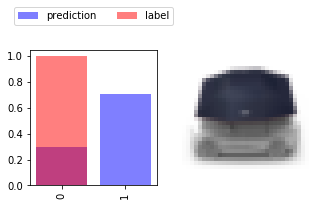

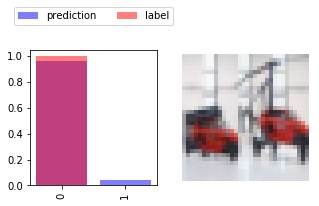

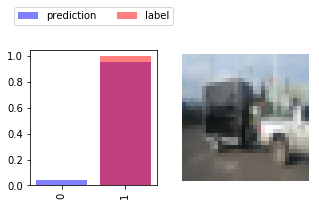

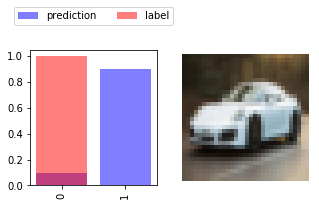

In [347]:
for x,y in test_generator_fn():
    if np.random.random()>.7:
        break
        
preds = model.predict(x)
show_preds(x, preds)

con los input pipielines del dataset API podemos consumir directamente imágenes desde ficheros también: [Decoding Image Data and Resizing it](https://www.tensorflow.org/guide/datasets#decoding_image_data_and_resizing_it)

## Capas convolucionales

seguramente la siguiente red te funcione mejor con imágenes más grandes y con más imágenes!!!

experimenta con [esta interacción](http://ml4a.github.io/demos/convolution_all/) para construirte la intuición de la convolución

fíjate que:

- la capa convolucional acepta directamente las imágenes (no hay `Flatten`)
- detrás de la capa convolucional creamos una red clásica como la anterior (**fully connected**)

In [348]:
def get_conv_model(num_classes, img_size=32, compile=True):
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(3,3), activation="relu")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model


In [349]:
model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=5,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)

Found 62 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 25s 249ms/step - loss: 0.0692 - acc: 0.9720 - val_loss: 1.1160 - val_acc: 0.7112
Epoch 2/5
100/100 [==============================] - 24s 241ms/step - loss: 0.0677 - acc: 0.9810 - val_loss: 1.3272 - val_acc: 0.7139
Epoch 3/5
100/100 [==============================] - 25s 249ms/step - loss: 0.0460 - acc: 0.9900 - val_loss: 1.3963 - val_acc: 0.7139
Epoch 4/5
100/100 [==============================] - 27s 265ms/step - loss: 0.0357 - acc: 0.9940 - val_loss: 1.5759 - val_acc: 0.7193
Epoch 5/5
100/100 [==============================] - 25s 249ms/step - loss: 0.0340 - acc: 0.9910 - val_loss: 1.6839 - val_acc: 0.7139


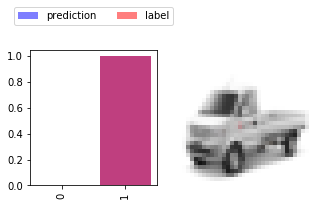

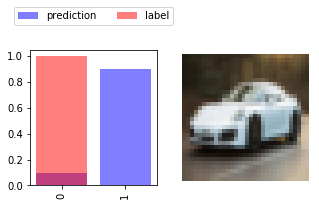

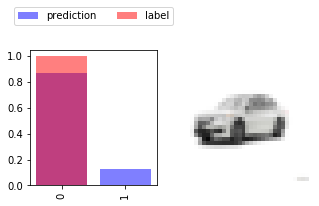

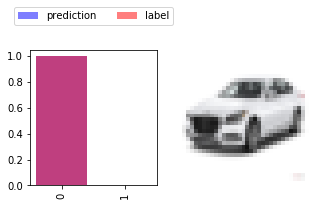

In [351]:
show_preds(x, preds)